# 03. Model Development
## Training Multiple Models for Trading Strategy

This notebook implements and trains various models including traditional ML and neural networks.

### Models to Train:
1. **Traditional ML**: Ridge, Random Forest, XGBoost
2. **Neural Networks**: FFNN
3. **Ensemble Methods**: Weighted averaging

In [18]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Traditional models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
# Check for Apple MPS (Metal) support on macOS (Apple Silicon) and prefer it when available.
mps_available = hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() and torch.backends.mps.is_built()
print(f"MPS available: {mps_available}")
if mps_available:
    device = torch.device('mps')
    print("Using device: MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using device: CUDA")
else:
    device = torch.device('cpu')
    print("Using device: CPU")

PyTorch version: 2.2.2
CUDA available: False
MPS available: True
Using device: MPS (Apple GPU)


## 1. Load Data and Feature Sets

In [19]:
# Load engineered features
X_all = pd.read_csv('../data/processed/engineered_features1.csv')
y = pd.read_csv('../data/processed/aligned_targets1.csv').squeeze()

# Load feature sets
with open('../data/processed/feature_sets1.json', 'r') as f:
    feature_sets = json.load(f)

print(f"Total samples: {len(X_all)}")
print(f"Total features: {len(X_all.columns)}")
print(f"\nAvailable feature sets:")
for name, features in feature_sets.items():
    print(f"  - {name}: {len(features)} features")

Total samples: 1499
Total features: 428

Available feature sets:
  - base: 10 features
  - temporal: 30 features
  - mi_top50: 50 features
  - rf_top50: 50 features
  - rfe_selected: 50 features
  - union: 82 features
  - all: 428 features


In [20]:
# Prepare train/validation/test split (70/15/15)
train_size = int(0.7 * len(X_all))
val_size = int(0.15 * len(X_all))

X_train = X_all.iloc[:train_size]
X_val = X_all.iloc[train_size:train_size+val_size]
X_test = X_all.iloc[train_size+val_size:]

y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:train_size+val_size]
y_test = y.iloc[train_size+val_size:]

print(f"Train: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier feature selection
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Train: (1049, 428)
Validation: (224, 428)
Test: (226, 428)


## 2. Traditional Machine Learning Models

In [21]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate and display model metrics."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Directional accuracy
    direction_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))
    
    # Information coefficient (rank correlation)
    from scipy.stats import spearmanr
    ic, _ = spearmanr(y_true, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Direction_Accuracy': direction_accuracy,
        'IC': ic
    }
    
    print(f"\n{model_name} Performance:")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"{metric:20s}: {value:.6f}")
    
    return metrics

In [22]:
# Train traditional models with different feature sets
models = {}
predictions = {}
results = {}

# Select feature set (using 'union' as it combines best features from multiple methods)
feature_set = feature_sets['union']
X_train_selected = X_train_scaled[feature_set]
X_val_selected = X_val_scaled[feature_set]

print(f"Using feature set 'union' with {len(feature_set)} features\n")

Using feature set 'union' with 82 features



In [23]:
# 1. Ridge Regression
print("Training Ridge Regression...")
ridge = Ridge(alpha=10.0, random_state=42)
ridge.fit(X_train_selected, y_train)
models['Ridge'] = ridge

# Predictions
y_pred_ridge = ridge.predict(X_val_selected)
predictions['Ridge'] = y_pred_ridge
results['Ridge'] = evaluate_model(y_val, y_pred_ridge, "Ridge Regression")

Training Ridge Regression...

Ridge Regression Performance:
----------------------------------------
MSE                 : 0.000082
RMSE                : 0.009045
MAE                 : 0.006798
R2                  : -1.440558
Direction_Accuracy  : 0.607143
IC                  : 0.105154


In [24]:
# 2. Random Forest
print("Training Random Forest...")
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_selected, y_train)
models['RandomForest'] = rf

y_pred_rf = rf.predict(X_val_selected)
predictions['RandomForest'] = y_pred_rf
results['RandomForest'] = evaluate_model(y_val, y_pred_rf, "Random Forest")

Training Random Forest...

Random Forest Performance:
----------------------------------------
MSE                 : 0.000030
RMSE                : 0.005454
MAE                 : 0.004233
R2                  : 0.112614
Direction_Accuracy  : 0.656250
IC                  : 0.312518


In [25]:
# 3. XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Try the sklearn-style fit first (supported in many xgboost versions).
# If the installed xgboost doesn't accept early_stopping_rounds on the sklearn wrapper,
# fall back to the native xgboost.train API and wrap the resulting Booster so the rest
# of the notebook can call .predict() and access feature_importances_.
try:
    xgb_model.fit(
        X_train_selected, y_train,
        eval_set=[(X_val_selected, y_val)],
        early_stopping_rounds=20,
        verbose=False
    )
    models['XGBoost'] = xgb_model
    y_pred_xgb = xgb_model.predict(X_val_selected)

except TypeError:
    # Fallback: use native xgboost.train
    dtrain = xgb.DMatrix(X_train_selected, label=y_train)
    dval = xgb.DMatrix(X_val_selected, label=y_val)

    # Build params from the sklearn estimator's params where applicable
    params = {
        'objective': 'reg:squarederror',
        'verbosity': 0,
    }
    params.update({
        'max_depth': xgb_model.get_params().get('max_depth', 4),
        'eta': xgb_model.get_params().get('learning_rate', 0.05),
        'subsample': xgb_model.get_params().get('subsample', 0.8),
        'colsample_bytree': xgb_model.get_params().get('colsample_bytree', 0.8),
        'alpha': xgb_model.get_params().get('reg_alpha', 0.1),
        'lambda': xgb_model.get_params().get('reg_lambda', 1.0),
        'seed': xgb_model.get_params().get('random_state', 42)
    })

    num_round = xgb_model.get_params().get('n_estimators', 300)

    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=num_round,
        evals=[(dval, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Wrapper so notebook code can call predict() and access feature_importances_
    class XGBoosterWrapper:
        def __init__(self, booster, feature_names=None):
            self.booster = booster
            self.feature_names = feature_names

        def predict(self, X):
            return self.booster.predict(xgb.DMatrix(X))

        @property
        def feature_importances_(self):
            # Return importances aligned to feature_names if available, otherwise numeric order
            scores = self.booster.get_score(importance_type='weight') or {}
            if self.feature_names is not None:
                return np.array([scores.get(name, 0.0) for name in self.feature_names], dtype=float)
            # fallback: return array for numeric feature indices
            max_idx = max([int(k[1:]) for k in scores.keys()]) + 1 if scores else 0
            arr = np.zeros(max_idx, dtype=float)
            for k, v in scores.items():
                idx = int(k[1:])
                arr[idx] = v
            return arr

    # create wrapper instance; pass feature_set (list of feature names) if available
    wrapper = XGBoosterWrapper(booster, feature_names=feature_set if 'feature_set' in globals() else None)
    xgb_model = wrapper
    models['XGBoost'] = xgb_model
    y_pred_xgb = xgb_model.predict(X_val_selected)

predictions['XGBoost'] = y_pred_xgb
results['XGBoost'] = evaluate_model(y_val, y_pred_xgb, "XGBoost")


Training XGBoost...

XGBoost Performance:
----------------------------------------
MSE                 : 0.000031
RMSE                : 0.005528
MAE                 : 0.004278
R2                  : 0.088291
Direction_Accuracy  : 0.660714
IC                  : 0.304312


In [26]:
# 4. LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(
    X_train_selected, y_train,
    eval_set=[(X_val_selected, y_val)],
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
)
models['LightGBM'] = lgb_model

y_pred_lgb = lgb_model.predict(X_val_selected)
predictions['LightGBM'] = y_pred_lgb
results['LightGBM'] = evaluate_model(y_val, y_pred_lgb, "LightGBM")

Training LightGBM...
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 3.12176e-05

LightGBM Performance:
----------------------------------------
MSE                 : 0.000031
RMSE                : 0.005587
MAE                 : 0.004337
R2                  : 0.068772
Direction_Accuracy  : 0.656250
IC                  : 0.312330


## 3. Neural Network Models

In [27]:
# Prepare data for neural networks (using all features)
X_train_nn = X_train_scaled.values
X_val_nn = X_val_scaled.values
y_train_nn = y_train.values
y_val_nn = y_val.values

# Create PyTorch datasets
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_nn),
    torch.FloatTensor(y_train_nn)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val_nn),
    torch.FloatTensor(y_val_nn)
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Neural network input shape: {X_train_nn.shape}")

Neural network input shape: (1049, 428)


In [28]:
# Simple Feed-Forward Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], dropout=0.3):
        super(FeedForwardNN, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

# Train function
def train_neural_network(model, train_loader, val_loader, epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [29]:
# Train Feed-Forward Neural Network
print("Training Feed-Forward Neural Network...")
input_size = X_train_nn.shape[1]
ffnn = FeedForwardNN(input_size).to(device)
ffnn, train_losses, val_losses = train_neural_network(ffnn, train_loader, val_loader, epochs=100)

# Make predictions
ffnn.eval()
with torch.no_grad():
    X_val_tensor = torch.FloatTensor(X_val_nn).to(device)
    outputs = ffnn(X_val_tensor).cpu()
    # Safe conversion: some environments may not have NumPy available at runtime.
    try:
        y_pred_ffnn = outputs.numpy()
    except Exception:
        # Fallback to Python list then to numpy array if numpy is importable
        y_pred_list = outputs.tolist()
        try:
            import numpy as _np
            y_pred_ffnn = _np.array(y_pred_list)
        except Exception:
            # Final fallback: keep as plain Python list
            y_pred_ffnn = y_pred_list

models['FFNN'] = ffnn
predictions['FFNN'] = y_pred_ffnn
results['FFNN'] = evaluate_model(y_val, y_pred_ffnn, "Feed-Forward NN")

Training Feed-Forward Neural Network...
Epoch 10/100 - Train Loss: 0.000801, Val Loss: 0.000114
Epoch 20/100 - Train Loss: 0.000060, Val Loss: 0.000036
Epoch 30/100 - Train Loss: 0.000035, Val Loss: 0.000033
Epoch 40/100 - Train Loss: 0.000027, Val Loss: 0.000033
Early stopping at epoch 43

Feed-Forward NN Performance:
----------------------------------------
MSE                 : 0.000034
RMSE                : 0.005807
MAE                 : 0.004491
R2                  : -0.005760
Direction_Accuracy  : 0.593750
IC                  : 0.252324


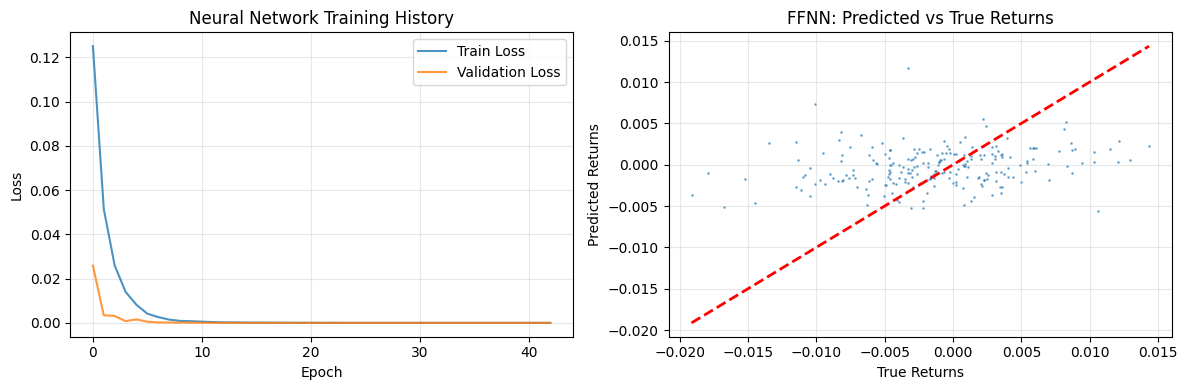

In [30]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training History')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_ffnn, alpha=0.5, s=1)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True Returns')
plt.ylabel('Predicted Returns')
plt.title('FFNN: Predicted vs True Returns')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Ensemble Methods

In [31]:
# Simple Weighted Ensemble
def create_weighted_ensemble(predictions, y_true, method='equal'):
    """Create weighted ensemble of predictions."""
    
    if method == 'equal':
        # Equal weights
        weights = np.ones(len(predictions)) / len(predictions)
    
    elif method == 'performance':
        # Weight by inverse MSE
        mses = []
        for name, pred in predictions.items():
            mse = mean_squared_error(y_true, pred)
            mses.append(mse)
        
        # Inverse MSE weights
        inv_mses = 1 / np.array(mses)
        weights = inv_mses / inv_mses.sum()
    
    elif method == 'optimize':
        # Optimize weights to minimize MSE
        from scipy.optimize import minimize
        
        pred_matrix = np.column_stack(list(predictions.values()))
        
        def objective(w):
            ensemble_pred = pred_matrix @ w
            return mean_squared_error(y_true, ensemble_pred)
        
        # Constraints: weights sum to 1, all non-negative
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = [(0, 1) for _ in range(len(predictions))]
        
        # Initial guess: equal weights
        w0 = np.ones(len(predictions)) / len(predictions)
        
        result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
        weights = result.x
    
    return weights

# Create ensembles
print("Creating ensemble models...\n")

# Get predictions from best models
ensemble_models = ['Ridge', 'RandomForest', 'XGBoost', 'LightGBM', 'FFNN']
ensemble_preds = {k: predictions[k] for k in ensemble_models if k in predictions}

# Equal weight ensemble
weights_equal = create_weighted_ensemble(ensemble_preds, y_val, method='equal')
pred_matrix = np.column_stack(list(ensemble_preds.values()))
y_pred_ensemble_equal = pred_matrix @ weights_equal
predictions['Ensemble_Equal'] = y_pred_ensemble_equal
results['Ensemble_Equal'] = evaluate_model(y_val, y_pred_ensemble_equal, "Ensemble (Equal Weights)")

# Performance-weighted ensemble
weights_perf = create_weighted_ensemble(ensemble_preds, y_val, method='performance')
y_pred_ensemble_perf = pred_matrix @ weights_perf
predictions['Ensemble_Performance'] = y_pred_ensemble_perf
results['Ensemble_Performance'] = evaluate_model(y_val, y_pred_ensemble_perf, "Ensemble (Performance Weights)")

# Optimized ensemble
weights_opt = create_weighted_ensemble(ensemble_preds, y_val, method='optimize')
y_pred_ensemble_opt = pred_matrix @ weights_opt
predictions['Ensemble_Optimized'] = y_pred_ensemble_opt
results['Ensemble_Optimized'] = evaluate_model(y_val, y_pred_ensemble_opt, "Ensemble (Optimized Weights)")

# Display ensemble weights
print("\nEnsemble Weights:")
print("-" * 50)
weights_df = pd.DataFrame({
    'Equal': weights_equal,
    'Performance': weights_perf,
    'Optimized': weights_opt
}, index=ensemble_models)
print(weights_df.round(3))

Creating ensemble models...


Ensemble (Equal Weights) Performance:
----------------------------------------
MSE                 : 0.000031
RMSE                : 0.005606
MAE                 : 0.004359
R2                  : 0.062369
Direction_Accuracy  : 0.629464
IC                  : 0.244934

Ensemble (Performance Weights) Performance:
----------------------------------------
MSE                 : 0.000030
RMSE                : 0.005502
MAE                 : 0.004281
R2                  : 0.097102
Direction_Accuracy  : 0.633929
IC                  : 0.294419

Ensemble (Optimized Weights) Performance:
----------------------------------------
MSE                 : 0.000031
RMSE                : 0.005606
MAE                 : 0.004359
R2                  : 0.062369
Direction_Accuracy  : 0.629464
IC                  : 0.244934

Ensemble Weights:
--------------------------------------------------
              Equal  Performance  Optimized
Ridge           0.2        0.087        0.2
Rando

## 5. Model Comparison


Model Performance Comparison (Validation Set)
                           MSE      RMSE       MAE        R2  \
RandomForest          0.000030  0.005454  0.004233  0.112614   
Ensemble_Performance  0.000030  0.005502  0.004281  0.097102   
XGBoost               0.000031  0.005528  0.004278  0.088291   
LightGBM              0.000031  0.005587  0.004337  0.068772   
Ensemble_Equal        0.000031  0.005606  0.004359  0.062369   
Ensemble_Optimized    0.000031  0.005606  0.004359  0.062369   
FFNN                  0.000034  0.005807  0.004491 -0.005760   
Ridge                 0.000082  0.009045  0.006798 -1.440558   

                      Direction_Accuracy        IC  
RandomForest                    0.656250  0.312518  
Ensemble_Performance            0.633929  0.294419  
XGBoost                         0.660714  0.304312  
LightGBM                        0.656250  0.312330  
Ensemble_Equal                  0.629464  0.244934  
Ensemble_Optimized              0.629464  0.244934  
FFNN 

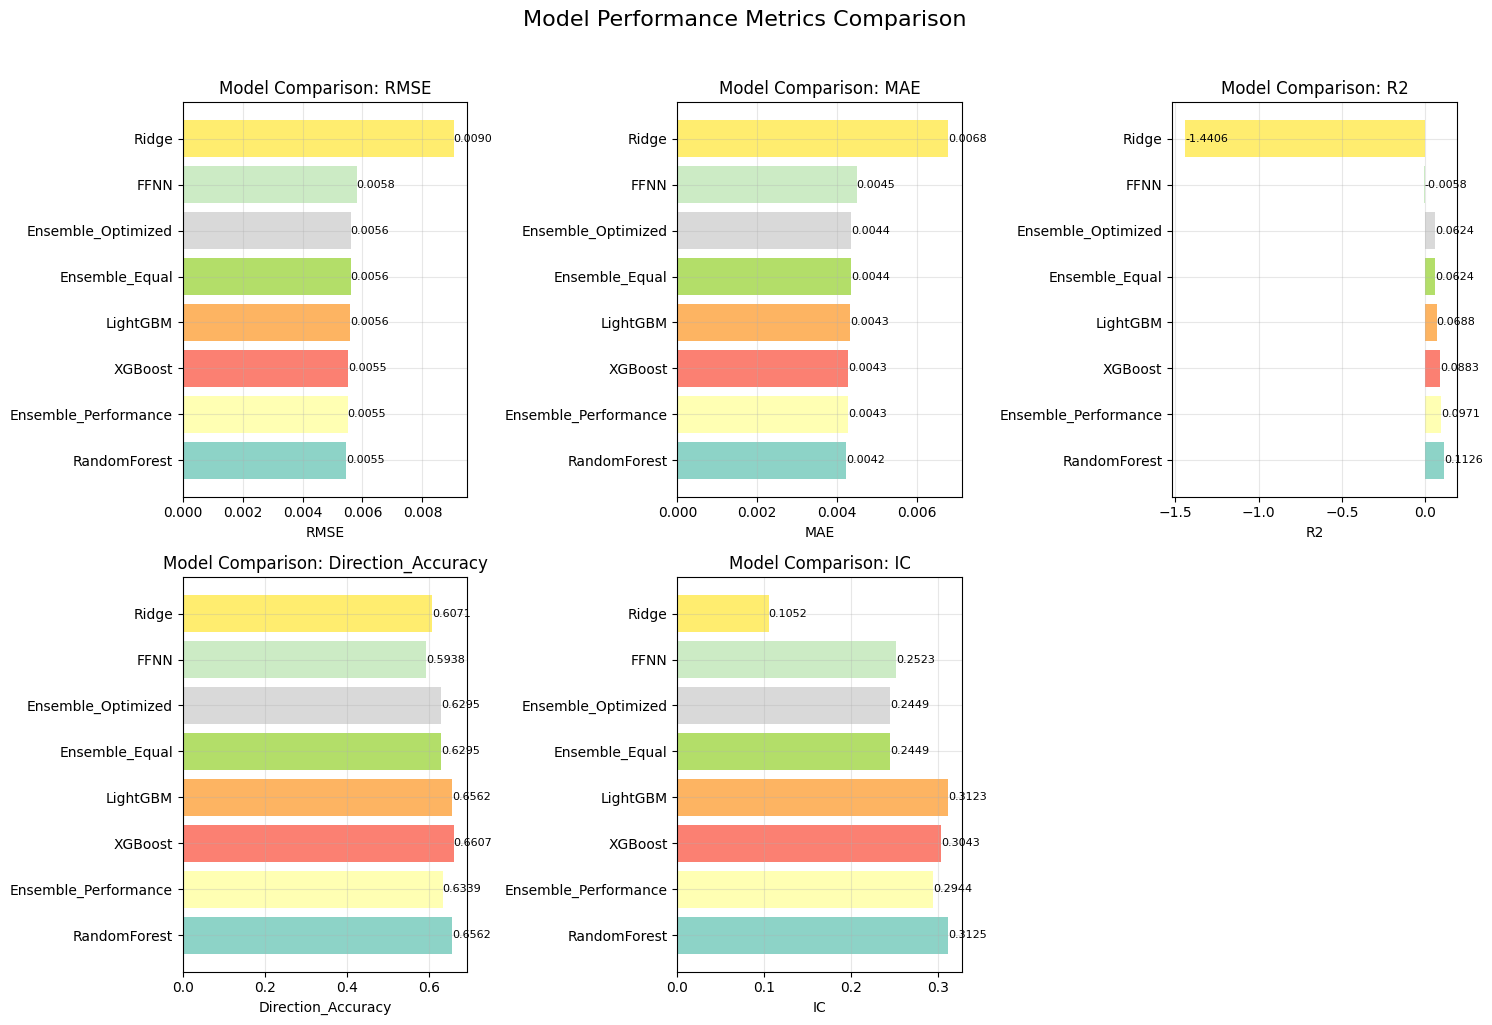

In [32]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('RMSE')

print("\nModel Performance Comparison (Validation Set)")
print("="*80)
print(comparison_df.round(6))

# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

metrics_to_plot = ['RMSE', 'MAE', 'R2', 'Direction_Accuracy', 'IC']
colors = plt.cm.Set3(np.linspace(0, 1, len(comparison_df)))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    values = comparison_df[metric].values
    models_sorted = comparison_df.index
    
    bars = ax.barh(range(len(models_sorted)), values, color=colors)
    ax.set_yticks(range(len(models_sorted)))
    ax.set_yticklabels(models_sorted)
    ax.set_xlabel(metric)
    ax.set_title(f'Model Comparison: {metric}')
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
                ha='left', va='center', fontsize=8)

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.suptitle('Model Performance Metrics Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

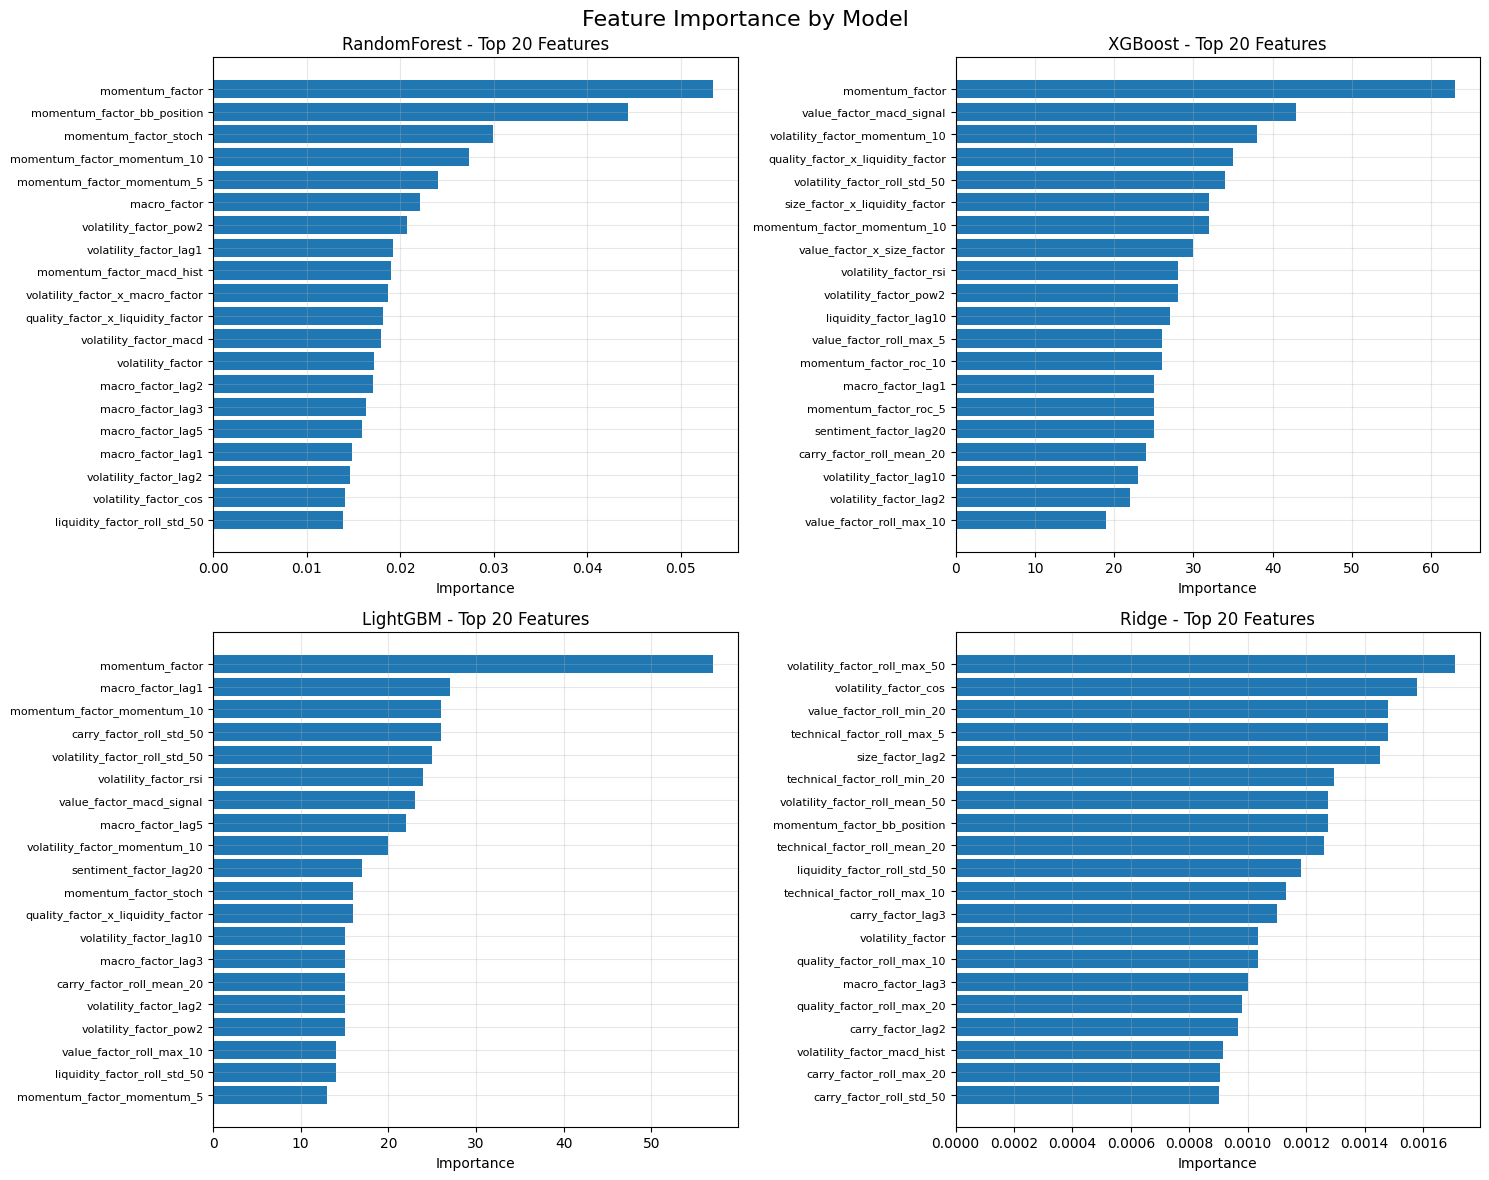

In [33]:
# Get feature importance from tree-based models
feature_importance_dict = {}

# Random Forest importance
rf_importance = pd.Series(rf.feature_importances_, index=feature_set).sort_values(ascending=False)
feature_importance_dict['RandomForest'] = rf_importance.head(20)

# XGBoost importance
xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_set).sort_values(ascending=False)
feature_importance_dict['XGBoost'] = xgb_importance.head(20)

# LightGBM importance
lgb_importance = pd.Series(lgb_model.feature_importances_, index=feature_set).sort_values(ascending=False)
feature_importance_dict['LightGBM'] = lgb_importance.head(20)

# Ridge coefficients (absolute values)
ridge_importance = pd.Series(np.abs(ridge.coef_), index=feature_set).sort_values(ascending=False)
feature_importance_dict['Ridge'] = ridge_importance.head(20)

# Plot feature importance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (model_name, importance) in enumerate(feature_importance_dict.items()):
    axes[idx].barh(range(len(importance)), importance.values)
    axes[idx].set_yticks(range(len(importance)))
    axes[idx].set_yticklabels(importance.index, fontsize=8)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{model_name} - Top 20 Features')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].invert_yaxis()

plt.suptitle('Feature Importance by Model', fontsize=16)
plt.tight_layout()
plt.show()

## 7. Save Models and Results

In [34]:
# Save models
import joblib
root_folder = '../'


# Save traditional models
for name in ['Ridge', 'RandomForest', 'XGBoost', 'LightGBM']:
    if name in models:
        joblib.dump(models[name], f'{root_folder}models/{name.lower()}_model1.pkl')
        print(f"✓ Saved {name} model")

# Save neural network
if 'FFNN' in models:
    torch.save(models['FFNN'].state_dict(), f'{root_folder}models/ffnn_model1.pth')
    print("✓ Saved FFNN model")

# Save scaler
joblib.dump(scaler, f'{root_folder}models/feature_scaler1.pkl')
print("✓ Saved feature scaler")

# Save predictions
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(f'{root_folder}data/results/validation_predictions1.csv', index=False)
print("✓ Saved validation predictions")

# Save results
comparison_df.to_csv(f'{root_folder}data/results/model_comparison1.csv')
print("✓ Saved model comparison results")

# Save ensemble weights
weights_df.to_csv(f'{root_folder}data/results/ensemble_weights1.csv')
print("✓ Saved ensemble weights")

print("\n" + "="*50)
print("Best performing model:", comparison_df.index[0])
print(f"Best RMSE: {comparison_df.iloc[0]['RMSE']:.6f}")
print(f"Best Direction Accuracy: {comparison_df.iloc[0]['Direction_Accuracy']:.4f}")
print(f"Best IC: {comparison_df.iloc[0]['IC']:.4f}")
print("="*50)

✓ Saved Ridge model
✓ Saved RandomForest model
✓ Saved XGBoost model
✓ Saved LightGBM model
✓ Saved FFNN model
✓ Saved feature scaler
✓ Saved validation predictions
✓ Saved model comparison results
✓ Saved ensemble weights

Best performing model: RandomForest
Best RMSE: 0.005454
Best Direction Accuracy: 0.6562
Best IC: 0.3125
